<a href="https://www.kaggle.com/code/keitayanagihara/spaceship-mycode?scriptVersionId=98173404" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# データ読み込み

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
submit = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [5]:
submit.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [6]:
!pip install sweetviz
import sweetviz as sv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 22.8 MB/s eta 0:00:00


In [7]:
# train のEDA
my_report_train = sv.analyze(train)
my_report_train.show_html("sweetviz_report_Spaceship_train_V1.html")

# train と test の関係
my_report_trainVStest = sv.compare([train, "Train"], [test, "Test"], "Transported")
my_report_trainVStest.show_html("sweetviz_report_Spaceship_trainVStest_V1.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_train_V1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_trainVStest_V1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# 前処理 
1. Cabin分裂(deck(encoding),side(encoding),num(そのまま))
2. HomePlanetとDestination合併
3. 家族(nameから)
4. 同室人数
5. カテゴリ変数の欠損値補完
6. カテゴリ変数の変換 (HomePlanet・Destination・CryoSleep・VIP・Transportedを数値変換)
7. PassengerId・Cabin・Nameを削除
8. clipping
9. binning

In [8]:
# Cabin分裂(deck(encoding),side(encoding),num(そのまま))

CabinAry_train = train["Cabin"].str.split("/", expand=True)
CabinAry_test = train["Cabin"].str.split("/", expand=True)

train["Cabin_Deck"] = CabinAry_train[0]
train["Cabin_Num"] = CabinAry_train[1]
train["Cabin_Side"] = CabinAry_train[2]

test["Cabin_Deck"] = CabinAry_test[0]
test["Cabin_Num"] = CabinAry_test[1]
test["Cabin_Side"] = CabinAry_test[2]

# Cabin_Num がoblect型になっていてlightgbmに突っ込めないからfloat型にする
train["Cabin_Num"] = train["Cabin_Num"].astype(float)
test["Cabin_Num"] = test["Cabin_Num"].astype(float)

In [9]:
# HomePlanetとDestination合併

train["Home×Dest"] = train["HomePlanet"] + train["Destination"]
test["Home×Dest"] = test["HomePlanet"] + test["Destination"]

In [10]:
# 家族(nameから)

train["Family"] = train["Name"].str.split(" ", expand=True)[1]
test["Family"] = test["Name"].str.split(" ", expand=True)[1]

In [11]:
# 同室人数

#初期値=0を設定
train["SameRoomNum"] = test["SameRoomNum"] = 0
CabinList_train = train["Cabin"].tolist()
CabinList_test = test["Cabin"].tolist()

for i in train.index.values:
    train["SameRoomNum"][i] = CabinList_train.count(train["Cabin"][i])
for i in test.index.values:
    test["SameRoomNum"][i] = CabinList_test.count(test["Cabin"][i])

train["SameRoomNum"].replace(199,np.nan, inplace=True)
test["SameRoomNum"].replace(100,np.nan, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


> 👆👆　**199をNANに戻したいけどうまくいかない ,　全探索だと時間がかかりすぎる**

In [12]:
test["SameRoomNum"].head(20)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     2.0
8     2.0
9     1.0
10    1.0
11    2.0
12    2.0
13    1.0
14    1.0
15    2.0
16    2.0
17    2.0
18    NaN
19    2.0
Name: SameRoomNum, dtype: float64

In [13]:
train["SameRoomNum"].head(20)

0     1.0
1     1.0
2     2.0
3     2.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     3.0
10    3.0
11    3.0
12    1.0
13    1.0
14    1.0
15    NaN
16    1.0
17    1.0
18    1.0
19    1.0
Name: SameRoomNum, dtype: float64

In [14]:
# カテゴリ変数の欠損値補完

cat_columns_train = ["HomePlanet","Destination","CryoSleep","VIP","Cabin_Deck","Cabin_Side", "Home×Dest", "Family", "Transported"]
cat_columns_test = ["HomePlanet","Destination","CryoSleep","VIP","Cabin_Deck","Cabin_Side", "Home×Dest", "Family"]

# 欠損値にunknowを代入
for c in cat_columns_train:
    train[c].fillna("unknow")
for c in cat_columns_test:
    test[c].fillna("unknow")

In [15]:
# カテゴリ変数の変換 (HomePlanet,Destination,CryoSleep,VIP,Cabin_Deck,Cabin_Side,Home×Dest,Family,Transported を数値変換)

from sklearn.preprocessing import LabelEncoder

for c in cat_columns_train:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])

for c in cat_columns_test:
    le = LabelEncoder()
    le.fit(test[c])
    test[c] = le.transform(test[c])

In [16]:
train.head(20)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Num,Cabin_Side,Home×Dest,Family,SameRoomNum
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0.0,0,5,1431,1.0
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,0.0,1,2,2109,1.0
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,0.0,1,5,1990,2.0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,0.0,1,5,1990,2.0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1.0,1,2,1778,1.0
5,0005_01,0,0,F/0/P,1,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1,5,0.0,0,1,977,1.0
6,0006_01,0,0,F/2/S,2,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,1,5,2.0,1,2,1080,1.0
7,0006_02,0,1,G/0/S,2,28.0,0,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,1,6,0.0,1,2,1080,1.0
8,0007_01,0,0,F/3/S,2,35.0,0,0.0,785.0,17.0,216.0,0.0,Andona Beston,1,5,3.0,1,2,168,1.0
9,0008_01,1,1,B/1/P,0,14.0,0,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,1,1,1.0,0,3,719,3.0


In [17]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Num,Cabin_Side,Home×Dest,Family,SameRoomNum
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0.0,0,5,1431,1.0
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,0.0,1,2,2109,1.0
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,0.0,1,5,1990,2.0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,0.0,1,5,1990,2.0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1.0,1,2,1778,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,A/98/P,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,98.0,0,3,1416,1.0
8689,9278_01,0,1,G/1499/S,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,6,1499.0,1,1,1341,1.0
8690,9279_01,0,0,G/1500/S,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,6,1500.0,1,2,470,1.0
8691,9280_01,1,0,E/608/S,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4,608.0,1,3,996,2.0


In [18]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_Deck,Cabin_Num,Cabin_Side,Home×Dest,Family,SameRoomNum
0,0013_01,0,1,G/3/S,2,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,0.0,0,2,275,1.0
1,0018_01,0,0,F/4/S,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,5,0.0,1,2,1190,1.0
2,0019_01,1,1,C/0/S,0,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0,0.0,1,3,1604,1.0
3,0021_01,1,0,C/1/S,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0,0.0,1,5,262,1.0
4,0023_01,0,0,F/5/S,2,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,5,1.0,1,2,736,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0,1,G/1496/S,2,34.0,0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,4,298.0,1,2,1209,1.0
4273,9269_01,0,0,NaN,2,42.0,0,0.0,847.0,17.0,10.0,144.0,Matty Scheron,5,853.0,1,2,1401,NaN
4274,9271_01,2,1,D/296/P,0,NaN,0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,5,937.0,0,6,1241,1.0
4275,9273_01,1,0,D/297/P,3,NaN,0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,2,143.0,0,9,362,1.0


In [19]:
# 前処理後の train のEDA
my_report_train = sv.analyze(train)
my_report_train.show_html("sweetviz_report_Spaceship_train_V2.html")

# 前処理後の train と test の関係
my_report_trainVStest = sv.compare([train, "Train"], [test, "Test"], "Transported")
my_report_trainVStest.show_html("sweetviz_report_Spaceship_trainVStest_V2.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_train_V2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_trainVStest_V2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [20]:
# PassengerId・Cabin・Nameを削除

train.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

In [21]:
# clipping

In [22]:
# binning

# 学習

In [23]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [24]:
X_train = train.drop(["Transported"], axis=1)
y_train = train["Transported"]

In [25]:
# StratifiedKFold fold=5 でとりあえず学習
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

score_list = []
models = []

for train_index, valid_index in fold.split(X_train, y_train):
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train.iloc[train_index]
    valid_y = y_train.iloc[valid_index]
    
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)
    
    # パラメータを定義
    lgbm_params = {'oblective': 'binary'}
    
    # 学習する
    gbm = lgb.train(params = lgbm_params,
                   train_set = lgb_train,
                   valid_sets = [lgb_train, lgb_valid],
                   early_stopping_rounds = 20, 
                   verbose_eval = -1 # 学習の状況を表示しない
                   )
    
    # スコアを算出する
    oof = (gbm.predict(valid_x) > 0.5).astype(int)
    score_list.append(round(accuracy_score(valid_y, oof)*100 ,2))
    models.append(gbm)
print(score_list, "平均score", round(np.mean(score_list), 2))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503595
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's l2: 0.0977301	valid_1's l2: 0.127588


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503595
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	training's l2: 0.0925475	valid_1's l2: 0.129194
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 16
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	training's l2: 0.0912167	valid_1's l2: 0.128336
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

In [26]:
# テストデータを与えて予測する

test_pred = np.zeros((len(test), 5))

for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(test)
    test_pred[:, fold_] = pred_
    
pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)

submit["Transported"] = pred
Transporteds = {0:False, 1:True}
submit["Transported"] = submit["Transported"].map(Transporteds)

submit.to_csv("spaceship_StratifiedKFold_5-fold_CV.csv", index=False)

In [27]:
# 特徴量重要度の表示

# for fold_, gbm in enumerate(models):
#     print(f"fold{fold_ + 1} feature_importance\n")
pd.DataFrame({"特徴":X_train.columns, "importance":gbm.feature_importance(importance_type="gain")}).sort_values("importance", ascending=False)

,特徴,importance
1,CryoSleep,1834.864813
8,Spa,531.503748
9,VRDeck,524.249173
6,FoodCourt,517.080820
11,Cabin_Num,387.790692
5,RoomService,359.914973
3,Age,352.004253
7,ShoppingMall,309.993165
10,Cabin_Deck,260.309987
13,Home×Dest,239.341087


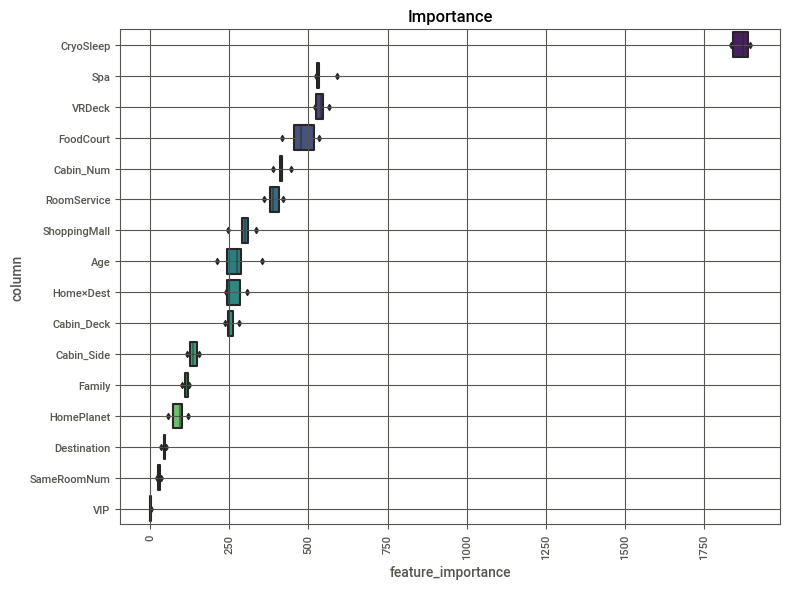

In [28]:
# 特徴量重要度の可視化

import seaborn as sns
import matplotlib.pyplot as plt
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance(importance_type="gain")
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_x)

In [29]:
X_train_dpCryo = train.drop(["Transported", "CryoSleep"], axis=1)
y_train = train["Transported"]

test_dpCryo = test.drop(["CryoSleep"], axis=1)

In [30]:
# CryoSleep 落として実験
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

score_list = []
models = []

for train_index, valid_index in fold.split(X_train_dpCryo, y_train):
    print(f"fold{fold_ + 1} start")
    train_x = X_train_dpCryo.iloc[train_index]
    valid_x = X_train_dpCryo.iloc[valid_index]
    train_y = y_train.iloc[train_index]
    valid_y = y_train.iloc[valid_index]
    
    lgb_train = lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)
    
    # パラメータを定義
    lgbm_params = {'oblective': 'binary'}
    
    # 学習する
    gbm = lgb.train(params = lgbm_params,
                   train_set = lgb_train,
                   valid_sets = [lgb_train, lgb_valid],
                   early_stopping_rounds = 20, 
                   verbose_eval = -1 # 学習の状況を表示しない
                   )
    
    # スコアを算出する
    oof = (gbm.predict(valid_x) > 0.5).astype(int)
    score_list.append(round(accuracy_score(valid_y, oof)*100 ,2))
    models.append(gbm)
print(score_list, "平均score", round(np.mean(score_list), 2))

fold5 start
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503595
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	training's l2: 0.0992339	valid_1's l2: 0.128271
fold5 start
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

Early stopping, best iteration is:
[45]	training's l2: 0.10123	valid_1's l2: 0.131939
fold5 start
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503595
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Early stopping, best iteration is:
[55]	training's l2: 0.0981191	valid_1's l2: 0.127714
fold5 start
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 15
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	training's l2: 0.0977658	valid_1's l2: 0.133108
fold5 start


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 15
[LightGBM] [Warning] Unknown parameter: oblective
[LightGBM] [Info] Start training from score 0.503666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	training's l2: 0.0986006	valid_1's l2: 0.129191
[80.45, 79.53, 81.25, 80.09, 80.49] 平均score 80.36


In [31]:
# テストデータを与えて予測する

test_pred = np.zeros((len(test_dpCryo), 5))

for fold_, gbm in enumerate(models):
    pred_ = gbm.predict(test_dpCryo)
    test_pred[:, fold_] = pred_
    
pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)

submit["Transported"] = pred
Transporteds = {0:False, 1:True}
submit["Transported"] = submit["Transported"].map(Transporteds)

submit.to_csv("spaceship_StratifiedKFold_5-fold_CV_dpCryo.csv", index=False)

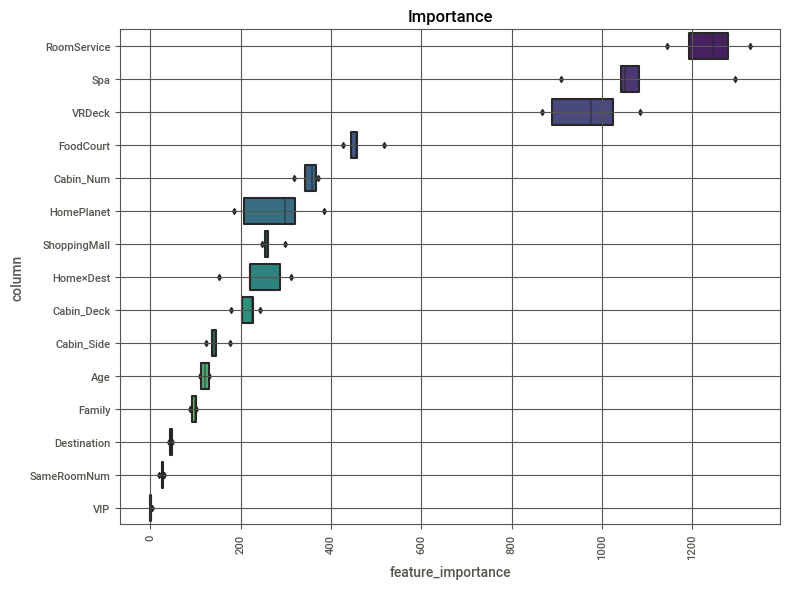

In [32]:
# 特徴量重要度の可視化

import seaborn as sns
import matplotlib.pyplot as plt
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance(importance_type="gain")
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_x)

# 課題
1. trainとtestをdfでまとめて特徴量を作る
2. for分を減らして実行速度上げる
3. 